In [526]:
# Data
import numpy as np
import pandas as pd

# Plot
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Pipeline
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline

# Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

# Validation
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
from sklearn.inspection import permutation_importance

import statsmodels.api as sm

# Others
import joblib
from datetime import datetime
import os

In [532]:
# --- File paths ---
fred_path = "../raw_data/FRED_FEDFUNDS, 1M.csv"
hourly_path = "../raw_data/Extract_TimeFrame_60_clean.csv"

In [533]:
# --- Load hourly file ---
df_h = pd.read_csv(hourly_path, sep=';')
df_h['time'] = pd.to_datetime(df_h['time'], dayfirst=True, errors='coerce', utc=True)
df_h = df_h.sort_values('time').sort_values('time').set_index('time')

# Keep NaN for trend + drop others
keep_na_cols = ['Down Trend', 'Up Trend']
check_cols = [c for c in df_h.columns if c not in keep_na_cols]
df_h = df_h.dropna(subset=check_cols, how='any')
df_h.head()

,open,high,low,close,Basis,Upper,Lower,Up Trend,Down Trend,KAMA,RSI,Bollinger Bands %b,Bollinger BandWidth,Highest Expansion,Lowest Contraction
time,,,,,,,,,,,,,,,
2022-01-11 00:00:00+00:00,1801.23,1802.85,1800.03,1801.18,1796.565,1802.85,1790.28,1790.975815,NaN,1795.256156,65.669045,0.831694,0.803134,2.519134,0.332677
2022-01-11 01:00:00+00:00,1801.16,1804.61,1801.15,1802.70,1797.445,1804.61,1790.28,1792.424234,NaN,1795.536505,69.806836,0.888896,0.826182,2.519134,0.332677
2022-01-11 02:00:00+00:00,1802.68,1805.91,1802.00,1804.85,1798.095,1805.91,1790.28,1793.371810,NaN,1795.896520,74.665739,0.963492,0.876434,2.519134,0.332677
2022-01-11 03:00:00+00:00,1804.83,1806.31,1804.21,1805.18,1798.295,1806.31,1790.28,1795.105129,NaN,1796.250762,75.350694,0.925586,0.917716,2.519134,0.332677
2022-01-11 04:00:00+00:00,1805.18,1807.73,1804.99,1805.91,1799.005,1807.73,1790.28,1796.398616,NaN,1796.635508,76.904655,0.915073,0.952947,2.519134,0.332677


In [485]:
# --- Load FRED monthly file ---
df_m = pd.read_csv(fred_path)
df_m['time'] = pd.to_datetime(df_m['time'], utc=True, errors='coerce')
df_m = df_m.sort_values('time')
#df_m = df_m.dropna(subset=['time'])
df_m = df_m.rename(columns={'close': 'FEDFUNDS'})
df_m.head()

,time,FEDFUNDS
0,1954-07-01 00:00:00+00:00,2.00
1,1954-08-01 00:00:00+00:00,1.22
2,1954-09-01 00:00:00+00:00,1.07
3,1954-10-01 00:00:00+00:00,0.85
4,1954-11-01 00:00:00+00:00,0.83


In [486]:
# --- Propagate monthly values to all hourly rows within the month ---
# Strategy: as-of merge from month-start rows backward, so every hour in a month gets that month's value.
df_h_reset = df_h.copy().reset_index()
df_m_reset = df_m.copy().rename(columns={'month_start': 'time'})
df_merged = pd.merge_asof(
    df_h_reset.sort_values('time'),
    df_m_reset.sort_values('time'),
    on='time',
    direction='backward'
).set_index('time')
df_merged.head()


,open,high,low,close,Basis,Upper,Lower,Up Trend,Down Trend,KAMA,RSI,Bollinger Bands %b,Bollinger BandWidth,Highest Expansion,Lowest Contraction,FEDFUNDS
time,,,,,,,,,,,,,,,,
2022-01-11 00:00:00+00:00,1801.23,1802.85,1800.03,1801.18,1796.565,1802.85,1790.28,1790.975815,NaN,1795.256156,65.669045,0.831694,0.803134,2.519134,0.332677,0.08
2022-01-11 01:00:00+00:00,1801.16,1804.61,1801.15,1802.70,1797.445,1804.61,1790.28,1792.424234,NaN,1795.536505,69.806836,0.888896,0.826182,2.519134,0.332677,0.08
2022-01-11 02:00:00+00:00,1802.68,1805.91,1802.00,1804.85,1798.095,1805.91,1790.28,1793.371810,NaN,1795.896520,74.665739,0.963492,0.876434,2.519134,0.332677,0.08
2022-01-11 03:00:00+00:00,1804.83,1806.31,1804.21,1805.18,1798.295,1806.31,1790.28,1795.105129,NaN,1796.250762,75.350694,0.925586,0.917716,2.519134,0.332677,0.08
2022-01-11 04:00:00+00:00,1805.18,1807.73,1804.99,1805.91,1799.005,1807.73,1790.28,1796.398616,NaN,1796.635508,76.904655,0.915073,0.952947,2.519134,0.332677,0.08


In [487]:
def chronological_split(X, y, train_ratio=0.7):
    """Chronological split (no shuffle). Returns X_train, X_val, y_train, y_val."""
    X = X.sort_index()
    y = y.loc[X.index]
    split_idx = int(np.floor(len(X) * train_ratio))
    return X.iloc[:split_idx], X.iloc[split_idx:], y.iloc[:split_idx], y.iloc[split_idx:]

def evaluate_metrics(y_true, y_pred, prefix=""):
    """Compute MAE, RMSE, R2 and print them."""
    mae = mean_absolute_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{prefix} MAE={mae:.6f} | RMSE={rmse:.6f} | R2={r2:.6f}")
    return {"MAE": mae, "RMSE": rmse, "R2": r2}

def learning_curves_time_series(estimator, X, y, train_sizes, n_splits=5, scoring='rmse'):
    """
    Time-series learning curves: for increasing train sizes, use TimeSeriesSplit folds.
    Returns arrays of avg train and validation scores.
    """
    train_scores = []
    val_scores = []

    for ts in train_sizes:
        X_sub = X.iloc[:ts]
        y_sub = y.iloc[:ts]

        tscv = TimeSeriesSplit(n_splits=n_splits)
        fold_train_scores, fold_val_scores = [], []

        for tr_idx, va_idx in tscv.split(X_sub):
            X_tr, X_va = X_sub.iloc[tr_idx], X_sub.iloc[va_idx]
            y_tr, y_va = y_sub.iloc[tr_idx], y_sub.iloc[va_idx]

            est = clone(estimator)
            est.fit(X_tr, y_tr)

            y_tr_pred = est.predict(X_tr)
            y_va_pred = est.predict(X_va)

            if scoring == 'rmse':
                tr = root_mean_squared_error(y_tr, y_tr_pred)
                va = root_mean_squared_error(y_va, y_va_pred)
            elif scoring == 'mae':
                tr = mean_absolute_error(y_tr, y_tr_pred)
                va = mean_absolute_error(y_va, y_va_pred)
            elif scoring == 'r2':
                tr = r2_score(y_tr, y_tr_pred)
                va = r2_score(y_va, y_va_pred)
            else:
                raise ValueError("Unsupported scoring")

            fold_train_scores.append(tr)
            fold_val_scores.append(va)

        train_scores.append(np.mean(fold_train_scores))
        val_scores.append(np.mean(fold_val_scores))

    return np.array(train_scores), np.array(val_scores)


In [488]:
class TrendEngineeringTransformer(BaseEstimator, TransformerMixin):
    """
    - Derive 'Trend' (categorical: 'Up'/'Down') from 'Up Trend' / 'Down Trend'.
    - Derive 'Trend_value' as row-wise sum of the two (skipna), and drop originals.
    - Derive 'Candle_mean' = high - low, and drop originals
    """
    def __init__(self, up_col='Up Trend', down_col='Down Trend', out_cat_col='Trend',
                 out_num_col='Trend_value', high_col='high', low_col='low',
                 out_candle_col='Candle_mean'):
        self.up_col = up_col
        self.down_col = down_col
        self.out_cat_col = out_cat_col
        self.out_num_col = out_num_col
        self.high_col = high_col
        self.low_col = low_col
        self.out_candle_col = out_candle_col

    def fit(self, X, y=None):
        # Nothing to learn
        return self

    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            raise TypeError("TrendEngineeringTransformer expects a pandas DataFrame.")

        X = X.copy()
        # 'Trend' = 'Up' if Up Trend not NaN else 'Down'
        X[self.out_cat_col] = np.where(X[self.up_col].notna(), 'Up', 'Down')
        # 'Trend_value' = Up Trend + Down Trend (skipna)
        X[self.out_num_col] = X[[self.up_col, self.down_col]].sum(axis=1, skipna=True)
        # 'Candle_mean' = high - low
        X[self.out_candle_col] = X[self.high_col] - X[self.low_col]

        # Drop originals if requested
        X = X.drop(columns=[self.up_col, self.down_col], errors='ignore')

        return X

    def set_output(self, *, transform=None):
        # No-op to be compatible with pipelines calling set_output
        return self


class CustomFeatureSelector(BaseEstimator, TransformerMixin):
    """
    Drop highly correlated numerical features (> threshold) based on upper triangle of correlation matrix.
    """
    def __init__(self, num_corr_threshold=0.95, method='pearson'):
        self.num_corr_threshold = num_corr_threshold
        self.method = method

    def fit(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            raise TypeError("CustomFeatureSelector expects a pandas DataFrame.")
        self.num_cols_ = list(X.select_dtypes(include=[np.number]).columns)
        if len(self.num_cols_) == 0:
            self.num_col_to_drop_ = []
            return self
        corr_num = X[self.num_cols_].corr(method=self.method)
        upper = corr_num.where(np.triu(np.ones(corr_num.shape), k=1).astype(bool)).abs()
        self.num_col_to_drop_ = [c for c in upper.columns if any(upper[c] > self.num_corr_threshold)]
        return self

    def transform(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            raise TypeError("CustomFeatureSelector expects a pandas DataFrame.")
        return X.drop(columns=getattr(self, 'num_col_to_drop_', []), errors='ignore')

    def set_output(self, *, transform=None):
        # No-op to be compatible with pipelines calling set_output
        return self

In [489]:
def build_preprocessing_pipeline(
    num_corr_threshold=0.95,
    trend_up_col='Up Trend',
    trend_down_col='Down Trend',
    trend_out_cat='Trend',
    trend_out_num='Trend_value',
    remove_features=False,
):
    # Dynamic numeric selector (after feature dropper); categorical encoder explicitly on 'Trend'
    num_selector = make_column_selector(dtype_include=np.number)
    cat_cols = [trend_out_cat]

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), num_selector),
            ('cat', OrdinalEncoder(categories=[['Down', 'Up']],
                                   handle_unknown='use_encoded_value', unknown_value=np.nan),
             cat_cols),
        ],
        remainder='drop'
    ).set_output(transform="pandas")

    if remove_features:
        pipe_new = Pipeline(steps=[
            ('trend_engineer', TrendEngineeringTransformer(up_col=trend_up_col, down_col=trend_down_col,
                                                        out_cat_col=trend_out_cat, out_num_col=trend_out_num
                                                        )),
            ('preprocess', preprocessor),
            ('corr_feature_dropper', CustomFeatureSelector(num_corr_threshold=num_corr_threshold, method='pearson'))
        ]).set_output(transform="pandas")
    else:
        pipe_new = Pipeline(steps=[
            ('trend_engineer', TrendEngineeringTransformer(up_col=trend_up_col, down_col=trend_down_col,
                                                        out_cat_col=trend_out_cat, out_num_col=trend_out_num
                                                        )),
            ('preprocess', preprocessor),
        ]).set_output(transform="pandas")

    return pipe_new

In [490]:
# --- Settings ---
horizon_hours=24
train_ratio=0.7
num_corr_threshold=0.95
plot_learning_curves=True

# Column names for preprocessing
trend_up_col='Up Trend'
trend_down_col='Down Trend'
trend_out_cat='Trend'
trend_out_num='Trend_value'
high_col='high'
low_col='low'
out_candle_col='Candle_mean'

target_source_col = 'close'

In [491]:
# --- Features and target ---
df = df_merged.sort_index().copy()
target_col = f"{target_source_col}_t+{horizon_hours}"
df[target_col] = df[target_source_col].shift(-horizon_hours)

# Drop values of the shift
df = df.dropna(subset=[target_col])

# Set close column as first column
cols = list(df.columns)
cols.remove(target_source_col)
cols.insert(0, target_source_col)
df = df[cols]

feature_cols = df.drop(columns=target_col).columns
X = df[feature_cols]
y = df[target_col]

In [492]:
# --- Split ---
X_train, X_val, y_train, y_val = chronological_split(X, y, train_ratio)

In [493]:
# Check the target
df[[target_source_col, target_col]].tail()

,close,close_t+24
time,,
2025-12-08 04:00:00+00:00,4210.09,4186.93
2025-12-08 05:00:00+00:00,4208.60,4179.83
2025-12-08 06:00:00+00:00,4217.10,4182.07
2025-12-08 07:00:00+00:00,4217.05,4182.43
2025-12-08 08:00:00+00:00,4206.91,4191.42


In [494]:
# Check the X split
display(X_train.tail(), X_val.head())

,close,open,high,low,Basis,Upper,Lower,Up Trend,Down Trend,KAMA,RSI,Bollinger Bands %b,Bollinger BandWidth,Highest Expansion,Lowest Contraction,FEDFUNDS
time,,,,,,,,,,,,,,,,
2024-10-04 19:00:00+00:00,2650.07,2645.41,2650.46,2644.02,2651.125,2670.2,2632.05,NaN,2668.052382,2653.386985,45.343834,0.232581,0.960165,1.585521,0.538254,4.83
2024-10-04 20:00:00+00:00,2645.63,2650.09,2650.79,2644.36,2651.125,2670.2,2632.05,NaN,2668.052382,2653.342273,41.332070,0.107137,1.029140,1.585521,0.538254,4.83
2024-10-04 21:00:00+00:00,2651.66,2645.63,2652.11,2642.78,2651.125,2670.2,2632.05,NaN,2668.052382,2653.322512,48.318270,0.337160,1.040737,1.585521,0.538254,4.83
2024-10-04 22:00:00+00:00,2653.54,2651.66,2653.96,2649.89,2651.125,2670.2,2632.05,NaN,2668.052382,2653.324479,50.390318,0.412176,1.043475,1.585521,0.538254,4.83
2024-10-07 00:00:00+00:00,2650.88,2651.13,2652.94,2649.58,2651.125,2670.2,2632.05,NaN,2668.052382,2653.313211,47.367451,0.331140,1.053242,1.585521,0.538254,4.83


,close,open,high,low,Basis,Upper,Lower,Up Trend,Down Trend,KAMA,RSI,Bollinger Bands %b,Bollinger BandWidth,Highest Expansion,Lowest Contraction,FEDFUNDS
time,,,,,,,,,,,,,,,,
2024-10-07 01:00:00+00:00,2650.17,2650.86,2652.44,2649.76,2651.125,2670.2,2632.05,NaN,2668.052382,2653.297360,46.529289,0.325304,1.042754,1.585521,0.538254,4.83
2024-10-07 02:00:00+00:00,2649.34,2650.15,2651.11,2647.83,2651.125,2670.2,2632.05,NaN,2668.052382,2653.238351,45.471119,0.315419,1.036321,1.585521,0.538254,4.83
2024-10-07 03:00:00+00:00,2646.21,2649.36,2651.96,2643.92,2651.125,2670.2,2632.05,NaN,2668.052382,2653.134965,41.469997,0.227948,1.012819,1.585521,0.538254,4.83
2024-10-07 04:00:00+00:00,2645.30,2646.23,2648.67,2645.30,2651.125,2670.2,2632.05,NaN,2668.052382,2653.001922,40.309866,0.209905,0.924488,1.585521,0.538254,4.83
2024-10-07 05:00:00+00:00,2647.42,2645.30,2647.46,2643.96,2651.125,2670.2,2632.05,NaN,2665.932931,2652.921039,44.387362,0.316992,0.896467,1.585521,0.538254,4.83


In [495]:
# Check the y split
display(y_train.tail(), y_val.head())

time
2024-10-04 19:00:00+00:00    2640.86
2024-10-04 20:00:00+00:00    2643.29
2024-10-04 21:00:00+00:00    2642.62
2024-10-04 22:00:00+00:00    2644.24
2024-10-07 00:00:00+00:00    2643.05
Name: close_t+24, dtype: float64

time
2024-10-07 01:00:00+00:00    2643.62
2024-10-07 02:00:00+00:00    2647.32
2024-10-07 03:00:00+00:00    2635.74
2024-10-07 04:00:00+00:00    2642.97
2024-10-07 05:00:00+00:00    2643.13
Name: close_t+24, dtype: float64

In [496]:
# --- Preprocessing pipeline ---
pipe_new = build_preprocessing_pipeline()
pipe_new

Pipeline(steps=[('trend_engineer', TrendEngineeringTransformer()),
                ('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x71a698964f10>),
                                                 ('cat',
                                                  OrdinalEncoder(categories=[['Down',
                                                                              'Up']],
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=nan),
                                                  ['Trend'])]))])

In [497]:
# --- Fit preprocessing ---
X_train_proc = pipe_new.fit_transform(X_train, y_train)
X_val_proc = pipe_new.transform(X_val)

In [498]:
# --- NaN check ---
processed_feature_names = pipe_new.named_steps['preprocess'].get_feature_names_out()
nan_frac_train = pd.Series(np.isnan(X_train_proc).mean(axis=0), index=processed_feature_names).sort_values(ascending=False)
print("NaN fraction per processed feature (TRAIN):\n", nan_frac_train)

NaN fraction per processed feature (TRAIN):
 num__close                  0.0
num__Bollinger Bands %b     0.0
num__Candle_mean            0.0
num__Trend_value            0.0
num__FEDFUNDS               0.0
num__Lowest Contraction     0.0
num__Highest Expansion      0.0
num__Bollinger BandWidth    0.0
num__RSI                    0.0
num__open                   0.0
num__KAMA                   0.0
num__Lower                  0.0
num__Upper                  0.0
num__Basis                  0.0
num__low                    0.0
num__high                   0.0
cat__Trend                  0.0
dtype: float64


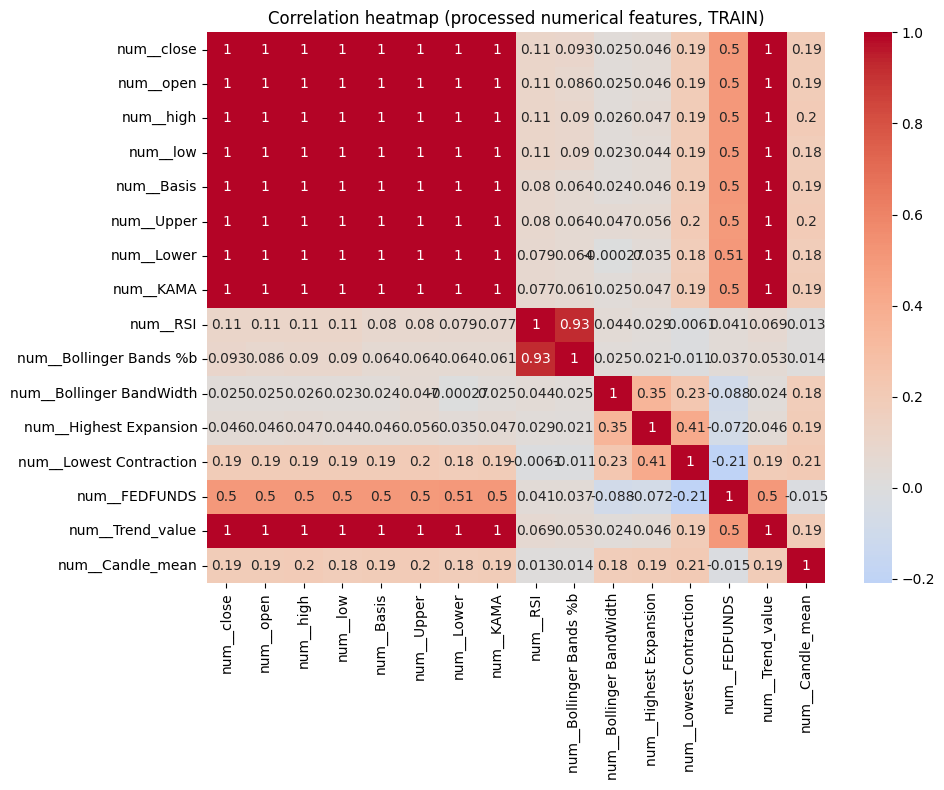

In [499]:
# --- Correlation check ---
num_names = [n for n in processed_feature_names if n.startswith('num__')]
num_idx = [list(processed_feature_names).index(n) for n in num_names]
X_train_num_df = pd.DataFrame(X_train_proc.iloc[:, num_idx], index=X_train.index, columns=num_names)

plt.figure(figsize=(10, 8))
sns.heatmap(X_train_num_df.corr(), cmap='coolwarm', center=0, annot=True)
plt.title('Correlation heatmap (processed numerical features, TRAIN)')
plt.tight_layout(); plt.show()

In [500]:
# --- Automatic clean pipe ---
pipe_auto = build_preprocessing_pipeline(remove_features=True)
pipe_auto

Pipeline(steps=[('trend_engineer', TrendEngineeringTransformer()),
                ('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x71a698965810>),
                                                 ('cat',
                                                  OrdinalEncoder(categories=[['Down',
                                                                              'Up']],
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=nan),
                                                  ['Trend'])])),
                ('corr_feature_dropper', CustomFeatureSelector())])

In [501]:
X_train_proc = pipe_auto.fit_transform(X_train, y_train)
X_val_proc = pipe_auto.transform(X_val)

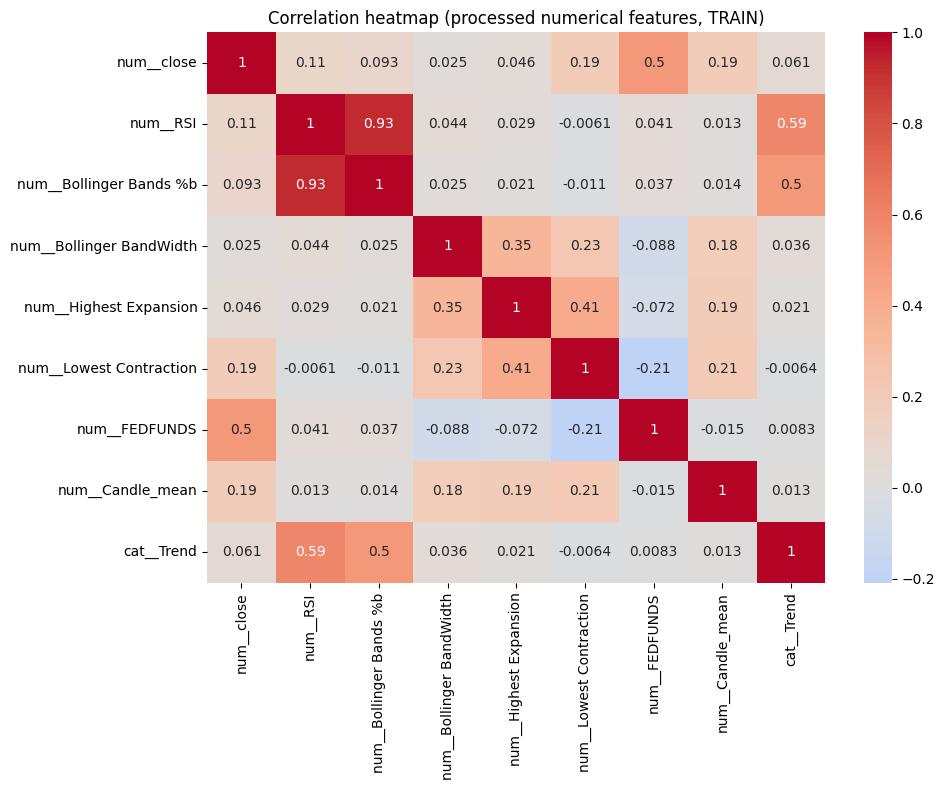

In [502]:
# --- Correlation check of preproc ---
plt.figure(figsize=(10, 8))
sns.heatmap(X_train_proc.corr(), cmap='coolwarm', center=0, annot=True)
plt.title('Correlation heatmap (processed numerical features, TRAIN)')
plt.tight_layout(); plt.show()

In [503]:
# List of dropped columns from the selector (pre-drop raw names)
dropper = pipe_auto.named_steps['corr_feature_dropper']
print("Correlated numeric features dropped by selector:", getattr(dropper, 'num_col_to_drop_', []))

Correlated numeric features dropped by selector: ['num__open', 'num__high', 'num__low', 'num__Basis', 'num__Upper', 'num__Lower', 'num__KAMA', 'num__Trend_value']


In [504]:
# --- Final model pipeline ---
model = LinearRegression()

pipe = Pipeline(steps=[
    ('preprocessing', pipe_auto),
    ('model', model)
])
pipe

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('trend_engineer',
                                  TrendEngineeringTransformer()),
                                 ('preprocess',
                                  ColumnTransformer(transformers=[('num',
                                                                   StandardScaler(),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x71a698965810>),
                                                                  ('cat',
                                                                   OrdinalEncoder(categories=[['Down',
                                                                                               'Up']],
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan),
                                                                   ['Trend'])])),
                                 ('corr_feature_dropper',
                                  CustomFeatureSelector())])),
                ('model', LinearRegression())])

In [505]:
# --- Fit and evaluate on validation ---
pipe.fit(X_train, y_train)
y_val_pred = pipe.predict(X_val)
metrics_val = evaluate_metrics(y_val, y_val_pred, prefix="Validation")

Validation MAE=28.567688 | RMSE=40.004734 | R2=0.993266


In [506]:
# --- Permutation importance ---
perm = permutation_importance(
    pipe, X_val, y_val,
    n_repeats=20, random_state=42, scoring='neg_root_mean_squared_error'
)
sorted_idx = np.argsort(perm.importances_mean)[::-1]
permutation_df = pd.DataFrame({
    "feature": np.array(processed_feature_names)[sorted_idx],
    "importance_mean": perm.importances_mean[sorted_idx],
    "importance_std": perm.importances_std[sorted_idx],
})
permutation_df

,feature,importance_mean,importance_std
0,num__close,648.929656,4.106560
1,num__high,90.329940,0.763004
2,num__low,89.941784,0.840872
3,num__Lowest Contraction,0.085332,0.026546
4,num__Highest Expansion,0.070489,0.014249
5,num__Trend_value,0.016519,0.004116
6,num__KAMA,0.007363,0.006782
7,num__Bollinger Bands %b,0.000000,0.000000
8,num__RSI,0.000000,0.000000
9,num__Lower,0.000000,0.000000


In [507]:
importance_df = pd.DataFrame(np.vstack((X_val.columns, perm.importances_mean)).T)
importance_df.columns=['feature','score decrease']
importance_df.sort_values(by="score decrease", ascending=False)

,feature,score decrease
0,close,648.929656
2,high,90.32994
3,low,89.941784
12,Bollinger BandWidth,0.085332
11,Bollinger Bands %b,0.070489
14,Lowest Contraction,0.016519
7,Up Trend,0.007363
1,open,0.0
4,Basis,0.0
5,Upper,0.0


In [508]:
# --- p-values check ---
X_train_df = pd.DataFrame(X_train_proc, index=X_train.index, columns=processed_feature_names)
X_train_df = X_train_df.dropna(axis=1, how='any')

X_train_sm = sm.add_constant(X_train_df)
ols_model = sm.OLS(y_train, X_train_sm).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:             close_t+24   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                 3.058e+05
Date:                Wed, 10 Dec 2025   Prob (F-statistic):               0.00
Time:                        18:35:43   Log-Likelihood:                -69677.
No. Observations:               16161   AIC:                         1.394e+05
Df Residuals:                   16151   BIC:                         1.395e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [509]:
# --- Remove features with p_value > 0.05 ---
features_to_remove = ["Lowest Contraction"] # To be adapted

X_train = X_train.drop(columns=features_to_remove, axis=1)
X_val = X_val.drop(columns=features_to_remove, axis=1)

# Make pipeline
pipe_auto = build_preprocessing_pipeline(remove_features=True)

# Add model
pipe = Pipeline(steps=[
    ('preprocessing', pipe_auto),
    ('model', model)
])

# Model fit
pipe.fit(X_train, y_train)

# Evaluate model
y_val_pred = pipe.predict(X_val)
metrics_val = evaluate_metrics(y_val, y_val_pred, prefix="Validation")

# Re check p-value
X_train_proc = pipe_auto.fit_transform(X_train, y_train)
X_train_df = pd.DataFrame(X_train_proc, index=X_train.index, columns=processed_feature_names)
X_train_df = X_train_df.dropna(axis=1, how='any')

X_train_sm = sm.add_constant(X_train_df)
ols_model = sm.OLS(y_train, X_train_sm).fit()
print(ols_model.summary())

Validation MAE=28.591143 | RMSE=40.023711 | R2=0.993260
                            OLS Regression Results                            
Dep. Variable:             close_t+24   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                 3.441e+05
Date:                Wed, 10 Dec 2025   Prob (F-statistic):               0.00
Time:                        18:35:53   Log-Likelihood:                -69678.
No. Observations:               16161   AIC:                         1.394e+05
Df Residuals:                   16152   BIC:                         1.394e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

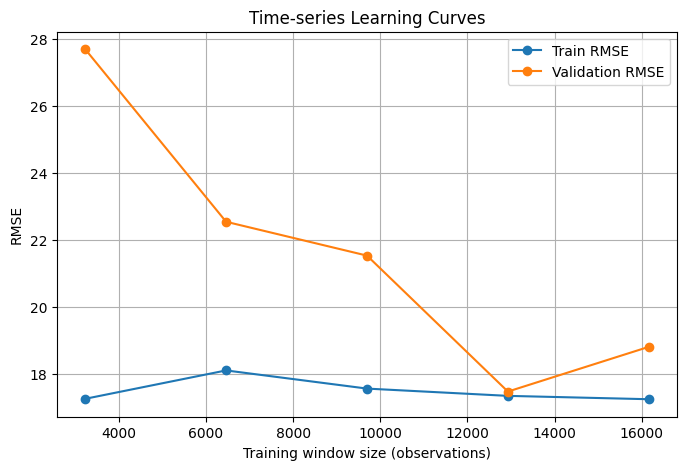

In [510]:
# --- Learning curves ---
if plot_learning_curves:
    # We build curves on TRAIN universe only (to avoid peeking into val)
    train_sizes = np.linspace(int(len(X_train) * 0.2), len(X_train), 5, dtype=int)
    lc_train, lc_val = learning_curves_time_series(pipe, X_train, y_train, train_sizes, n_splits=5, scoring='rmse')
    learning_curves = {"sizes": train_sizes, "train_rmse": lc_train, "val_rmse": lc_val}

    plt.figure(figsize=(8,5))
    plt.plot(train_sizes, lc_train, 'o-', label='Train RMSE')
    plt.plot(train_sizes, lc_val, 'o-', label='Validation RMSE')
    plt.xlabel('Training window size (observations)')
    plt.ylabel('RMSE')
    plt.title('Time-series Learning Curves')
    plt.legend()
    plt.grid(True)
    plt.show()

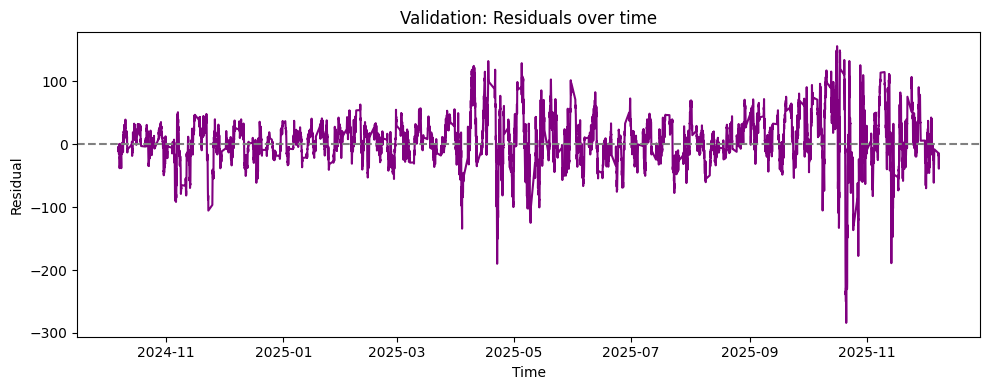

In [511]:
# --- Residuals plot ---
residuals = y_val - y_val_pred

plt.figure(figsize=(10,4))
plt.plot(y_val.index, residuals, color='purple'); plt.axhline(0, color='gray', linestyle='--')
plt.title('Validation: Residuals over time'); plt.xlabel('Time'); plt.ylabel('Residual')
plt.tight_layout(); plt.show()

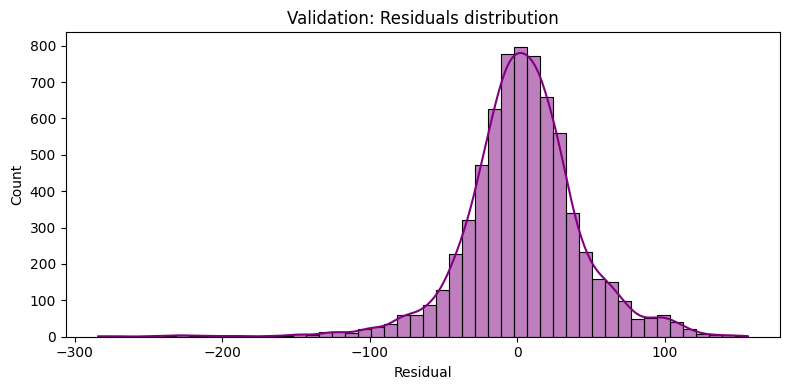

In [512]:
plt.figure(figsize=(8,4))
sns.histplot(residuals, bins=50, kde=True, color='purple')
plt.title('Validation: Residuals distribution'); plt.xlabel('Residual')
plt.tight_layout(); plt.show()

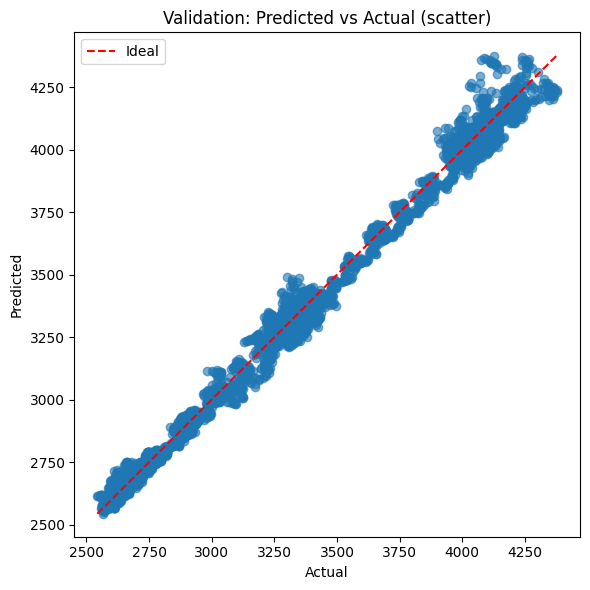

In [513]:
# --- Pred vs actual plots ---
plt.figure(figsize=(6,6))
plt.scatter(y_val, y_val_pred, alpha=0.6)
lims = [min(y_val.min(), y_val_pred.min()), max(y_val.max(), y_val_pred.max())]
plt.plot(lims, lims, 'r--', label='Ideal')
plt.title('Validation: Predicted vs Actual (scatter)')
plt.xlabel('Actual'); plt.ylabel('Predicted')
plt.legend(); plt.tight_layout(); plt.show()

In [514]:
y_train_s = pd.Series(y_train, index=y_train.index)
y_val_s = pd.Series(y_val, index=y_val.index)
y_val_pred_s = pd.Series(y_val_pred, index=y_val.index)

df_train = pd.DataFrame({'time': y_train_s.index, 'series': 'Train', 'value': y_train_s.values})
df_actual = pd.DataFrame({'time': y_val_s.index, 'series': 'Actual', 'value': y_val_s.values})
df_pred = pd.DataFrame({'time': y_val_pred_s.index, 'series': 'Predicted', 'value': y_val_pred_s.values})

df_plot = pd.concat([df_train, df_actual, df_pred], axis=0, ignore_index=True)

fig1 = px.line(
    df_plot,
    x='time', y='value', color='series',
    title='Validation: Actual vs Predicted (with Train)',
    labels={'time': 'Time', 'value': 'Target', 'series': 'Series'},
)
fig1.update_layout(template='plotly_white', legend=dict(title=None), title_x=0.5)
fig1.show()

In [515]:
y_val_diff = y_val_s.diff()
y_val_pred_diff = y_val_pred_s.diff()

df_diff_actual = pd.DataFrame({'time': y_val_diff.index, 'series': 'Actual Δ', 'diff': y_val_diff.values})
df_diff_pred   = pd.DataFrame({'time': y_val_pred_diff.index, 'series': 'Predicted Δ', 'diff': y_val_pred_diff.values})

df_diff_plot = pd.concat([df_diff_actual, df_diff_pred], axis=0, ignore_index=True)

fig2 = px.line(
    df_diff_plot,
    x='time', y='diff', color='series',
    title='Validation: Actual vs Predicted Differences (Δ)',
    labels={'time': 'Time', 'diff': 'Difference', 'series': 'Series'},
)
fig2.update_layout(template='plotly_white', legend=dict(title=None), title_x=0.5)
fig2.show()

<Axes: xlabel='close_t+24', ylabel='Count'>

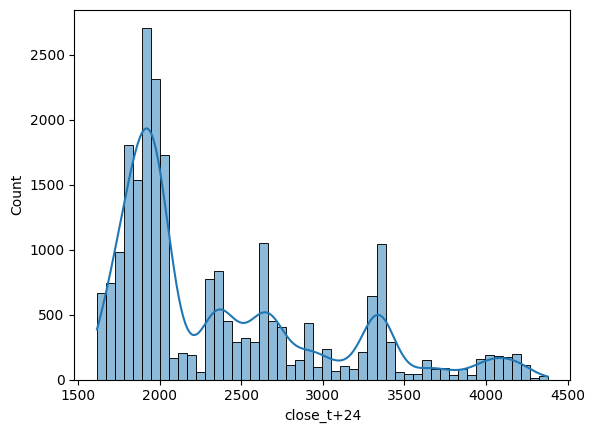

In [516]:
# --- Target plot ---
sns.histplot(y, kde=True)

In [517]:
# --- Fit on full dataset ---
pipe_final = Pipeline(steps=[
    ('preprocessing', pipe_auto),
    ('model', clone(model))
])
pipe_final.fit(X, y)

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('trend_engineer',
                                  TrendEngineeringTransformer()),
                                 ('preprocess',
                                  ColumnTransformer(transformers=[('num',
                                                                   StandardScaler(),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x71a6989f7580>),
                                                                  ('cat',
                                                                   OrdinalEncoder(categories=[['Down',
                                                                                               'Up']],
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan),
                                                                   ['Trend'])])),
                                 ('corr_feature_dropper',
                                  CustomFeatureSelector())])),
                ('model', LinearRegression())])

In [518]:
# --- Global evaluation ---
y_full_pred_in_sample = pipe_final.predict(X)
metrics_full_in_sample = evaluate_metrics(y, y_full_pred_in_sample, prefix="Global (in-sample)")

Global (in-sample) MAE=17.929090 | RMSE=26.493598 | R2=0.998393


In [519]:
# --- Cross validate ---
tscv = TimeSeriesSplit(n_splits=5)
fold_results = []
for i, (tr_idx, va_idx) in enumerate(tscv.split(X)):
    X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
    y_tr, y_va = y.iloc[tr_idx], y.iloc[va_idx]
    pipe_fold = clone(pipe)
    pipe_fold.fit(X_tr, y_tr)
    y_va_pred = pipe_fold.predict(X_va)
    m = evaluate_metrics(y_va, y_va_pred, prefix=f"Global CV fold {i+1}")
    fold_results.append(m)
metrics_full_cv = {
    "MAE": np.mean([fr["MAE"] for fr in fold_results]),
    "RMSE": np.mean([fr["RMSE"] for fr in fold_results]),
    "R2": np.mean([fr["R2"] for fr in fold_results]),
    "folds": fold_results
}
print(f"Global CV avg: MAE={metrics_full_cv['MAE']:.6f} | RMSE={metrics_full_cv['RMSE']:.6f} | R2={metrics_full_cv['R2']:.6f}")

Global CV fold 1 MAE=22.665125 | RMSE=27.920231 | R2=0.944345
Global CV fold 2 MAE=11.138944 | RMSE=14.715544 | R2=0.912107
Global CV fold 3 MAE=16.940720 | RMSE=22.471067 | R2=0.979069
Global CV fold 4 MAE=20.021041 | RMSE=26.630048 | R2=0.977542
Global CV fold 5 MAE=34.445410 | RMSE=47.310830 | R2=0.980901
Global CV avg: MAE=21.042248 | RMSE=27.809544 | R2=0.958793


In [535]:
# --- GridSearch ---
from tempfile import mkdtemp
cache_dir = mkdtemp()

pipe_auto = build_preprocessing_pipeline(remove_features=True)

# Models
models = {
    #'model_gbm': GradientBoostingRegressor(random_state=42), # for this model GridSearch n_jobs should be =1
    'model_rf': RandomForestRegressor(random_state=42, n_jobs=-1),
    #'model_dt': DecisionTreeRegressor(random_state=42), # for this model GridSearch n_jobs should be =1
    #'model_svm': SVR(), # for this model GridSearch n_jobs should be =1
    #'model_ada': AdaBoostRegressor(random_state=42), # for this model GridSearch n_jobs should be =1
	'model_xgb': XGBRegressor(random_state=42, n_jobs=-1),
    'model_lin': LinearRegression(),
}

# params = {
#     'model_gbm': {'model__learning_rate':[0.1,0.2,0.3,0.4], 'model__n_estimators':[50,100,500,1000,2000], 'model__max_depth':[3,5,7]},
#     'model_rf':  {'model__n_estimators':[50,100,500,1000,2000], 'model__max_depth':[2,5,7,10,20]},
#     'model_dt':  {'model__splitter':['best','random'], 'model__max_depth':[2,5,7,10,20,50]},
#     'model_svm': {'model__C':[1,2,5,10,50,100,500], 'model__kernel':['rbf','poly','sigmoid','linear'], 'model__degree':[2,3,4], 'model__gamma':['scale','auto']},
#     'model_ada': {'model__n_estimators':[10,20,30,50,100,500,1000], 'model__learning_rate':[0.5,1,2,5,10]},
# 	'model_xgb': {'model__n_estimators':[50,100,500,1000], 'model__learning_rate':[0.01,0.05,0.1,0.2], 'model__max_depth':[3,5,7,10]}
# }

params = {
    #'model_gbm': {'model__learning_rate':[0.05, 0.1], 'model__n_estimators':[200, 500], 'model__max_depth':[3, 5]},
    'model_rf':  {'model__n_estimators':[300, 600], 'model__max_depth':[10, 20], 'model__min_samples_leaf': [1, 5]},
    #'model_dt':  {'model__splitter':['best', 'random'], 'model__max_depth':[5, 10, 20], 'model__min_samples_leaf': [1, 5, 10]},
    #'model_svm': {'model__C':[1, 10, 100], 'model__kernel':['rbf'], 'model__degree':[2, 3], 'model__gamma':['scale','auto']},
	'model_xgb': {'model__n_estimators':[300, 600], 'model__learning_rate':[0.05, 0.1], 'model__max_depth': [3, 6, 9]},
    'model_lin': {'model__fit_intercept': [True, False]},
}

# Time-series CV & scoring (RMSE)
tscv = TimeSeriesSplit(n_splits=5)
scoring = 'neg_root_mean_squared_error'

best_overall_score = -np.inf # neg-rmse

best_models = {}
for name, model in models.items():
    final_pipe = Pipeline([
        ('preprocessing', pipe_auto),
        ('model', model)
    ], memory=cache_dir)
    grid = params.get(name, {})
    if hasattr(model, 'n_jobs'):
        search = GridSearchCV(final_pipe, grid, scoring=scoring, cv=tscv, n_jobs=1, verbose=1)
    else:
        search = GridSearchCV(final_pipe, grid, scoring=scoring, cv=tscv, n_jobs=-1, verbose=1)
    search.fit(X_train, y_train)

    # Keep best pipeline per family
    best_models[name] = search.best_estimator_
    print(f"{name}: Best params -> {search.best_params_}, Score -> {search.best_score_:.6f}")

    # Track champion
    if search.best_score_ > best_overall_score:
        best_overall_score = search.best_score_
        best_overall_name = name
        best_overall_pipe = search.best_estimator_
        best_overall_params = search.best_params_

print("\nChampion model:", best_overall_name)
print("Champion best_score_ (RMSE):", best_overall_score)
print("Champion params:", best_overall_params)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
model_rf: Best params -> {'model__max_depth': 10, 'model__min_samples_leaf': 5, 'model__n_estimators': 300}, Score -> -112.914711
Fitting 5 folds for each of 12 candidates, totalling 60 fits
model_xgb: Best params -> {'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__n_estimators': 300}, Score -> -99.908589
Fitting 5 folds for each of 2 candidates, totalling 10 fits
model_lin: Best params -> {'model__fit_intercept': True}, Score -> -18.799615

Champion model: model_lin
Champion best_score_ (RMSE): -18.799615447252613
Champion params: {'model__fit_intercept': True}


In [536]:
# --- Evaluate champion ---
y_val_pred = best_overall_pipe.predict(X_val)
metrics_val = evaluate_metrics(y_val, y_val_pred, prefix="Hold-out (X_val)")

Hold-out (X_val) MAE=28.591143 | RMSE=40.023711 | R2=0.993260


In [537]:
# --- Save champion pipeline ---
ts = datetime.now().strftime("%Y%m%d_%H%M%S")
champion_path = f"../models/{ts}_champion_{best_overall_name}.pkl"
joblib.dump(best_overall_pipe, champion_path)
print(f"Saved champion pipeline -> {champion_path}")

Saved champion pipeline -> ../models/20251210_190038_champion_model_lin.pkl


In [524]:
# --- Load and predict ---
champion = joblib.load(champion_path)
y_val_pred = champion.predict(X_val)

In [ ]:
# Final dictionnary results
results = {
    "preprocessing": pipe_auto,
    "processed_feature_names": list(processed_feature_names),
    "nan_frac_train": nan_frac_train,
    "dropped_numeric_features": getattr(dropper, 'num_col_to_drop_', []),
    "pipeline_val": pipe,                # train-only fit
    "metrics_val": metrics_val,
    "permutation_importance": permutation_df,
    "ols_summary_text": ols_model.summary().as_text(),
    "final_pipeline": pipe_final,        # full-data fit
    "metrics_full_in_sample": metrics_full_in_sample,
    "metrics_full_cv": metrics_full_cv,
    "target_col": target_col
}